# Chibuzo Ukegbu 
# PS2

## Collaborator: None




# CS534 Homework 2

Put your homework in the directory with your name. Please mention in this file the names of any students with whom you collaborated. If you didn't collaborate with anyone, mark your collaborators as "None." Remember, your goal is to communicate. Full credit will be given only to correct solutions which are described clearly. Convoluted and obtuse descriptions will receive low marks. To complete your homework, you may ONLY consult the following material:

lecture slides
course notes you or others took during lecture.
the required text
websites that may clarify the concepts covered in the material but do not in any way provide complete solutions to the problems.

Please provide an answer to the following question:
# Question 1 (15 pts)
Implement the fit and predict procedures for the logistic regression (scikit is not allowed) with norm 2 regularization function (and Lambda parameter).
Use as the input parameters of the gradient ascent the maximum number of iterations (just a constant e.g 100) and the learning factor (e.g. 0.01).


## Basic Configurations

In [1]:
from sklearn.datasets import load_iris
from sklearn import datasets
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.metrics import classification_report

In [2]:
class MyLogisReg:
    '''
        The maximum number of iteration => num_iter
        Learning Factor => lf
        Sigmoid Function => sigmoid
        Cross-Entropy Loss Function => ce_loss
        L2 Regularization lambda => lamd
    '''
    def __init__(self, num_iter=100, lf=0.01, lamd=0):
        self.lf = lf
        self.lamd = lamd
        self.num_iter = num_iter
        self.num_feat = X.shape[1]
        self.num_data = X.shape[0]
        self.weight_init()

    def weight_init(self):
        self.w = np.zeros(self.num_feat)
        self.b = 0
        
    def __repr__(self):
        op = "Learning Factor: {}, \nNumber of iterations: {}, \nL2 Lambda Parameter: {},\nWeights: {}, {} \n".format(self.lf, self.num_iter, self.lamd, self.w, self.b)
        return op
    
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
       
    def ce_loss(self, h, y):
        return (y * np.log(h) + (1 - y) * np.log(1 - h)).mean()
    
    def gradient(self, X, y, h):
        weight_grad = np.dot(X.T, (y - h))
        bias_grad = np.sum((y - h))
        #(np.dot(X.T, (y - h))) / self.num_data
        return weight_grad, bias_grad
    
    def fit(self, X, y, verbose=0):
        for i in range(self.num_iter):
            z = np.dot(X, self.w)
            h = self.sigmoid(z)
            self.w += self.lf * (self.gradient(X, y, h)[0] - 2*self.lamd * self.w)
            self.b += self.lf*self.gradient(X, y, h)[1]
            #(y - h).mean()
            
            if i % (self.num_iter/10) == 0 and verbose:
                print("Cost after {} iterations: {}".format(i, self.ce_loss(h, y)))
    
    def predict(self, X):
        return self.sigmoid(np.dot(X, self.w)+self.b).round()

## Demo 1:

In [3]:
iris = datasets.load_iris()
X = iris.data[:, :2]
y = (iris.target != 0) * 1

model = MyLogisReg(100, 0.01, 0.1)

model.fit(X, y, 0)
print(model)

p = model.predict(X)
accuracy = np.sum(p==y)/p.shape[0]*100
print(" The accuracy on training is {:.5f}".format(accuracy))

Learning Factor: 0.01, 
Number of iterations: 100, 
L2 Lambda Parameter: 0.1,
Weights: [ 4.7266319  -8.18740767], -1.519252154383145 

 The accuracy on training is 97.33333


# Question 2 (20 pts)
Use the iris dataset (just the binary class Iris Setosa vs others), the K-fold cross validation, metrics(accuracy, precision, recall, F1-score) and the logistic regression with L2 regularization.
You can use scikit.
Please estimate the best parameter C(the inverse of lambda)

# Load Data

In [4]:
X = load_iris().data
Y = load_iris().target

# Make the class setosa have value of 0, and all other classes have value of 1
setosa_index = list(load_iris().target_names).index("setosa")
Y[load_iris().target == setosa_index] = 0
Y[load_iris().target != setosa_index] = 1

X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.33,
    shuffle=True, stratify=Y,  
    random_state= 100  
)

def train_logreg(X_train, y_train, C=1):
    # Initialize the metrics
    metrics = {'accuracy':[], 'precision':[], 'recall':[], 'fscore':[]}

    # Train and test on K-fold splits
    kf = KFold(n_splits=10,random_state=10,shuffle=True)
    for train_index, test_index in kf.split(X_train):
        # Split the data
        x1, x2 = X_train[train_index], X_train[test_index]
        y1, y2 = y_train[train_index], y_train[test_index]

        # Train the logistic regression model
        model = MyLogisReg(num_iter=100, lf=0.01, lamd=0.1)
        model.fit(x1, y1)

        # Evaluate the model
        Y_pred = model.predict(x2)
        precis, recall, fscore, _ = precision_recall_fscore_support(y2, Y_pred, average='micro')
        metrics['accuracy'].append(accuracy_score(y2, Y_pred))
        metrics['precision'].append(precis)
        metrics['recall'].append(recall)
        metrics['fscore'].append(fscore)

    # Take the average of the metrics
    for k in metrics.keys():
        metrics[k] = np.mean(metrics[k])
        return metrics

In [5]:
# Perform a grid search to find the best C value
history = {'C': [], 'fscore': [], 'precision': [], 'recall': [], 'accuracy':[]}
grid_search_iterations = 15
best_quality = -np.inf
search_range = (np.finfo(float).eps, 100000)

for _ in range(grid_search_iterations):
    # Create a search space
    prev_quality = best_quality
    search_space = np.linspace(search_range[0], search_range[1], num=10)

    # Calculate the quality for each C
    search_quality = []
    for C in search_space:
        metrics = train_logreg(X_train, y_train, C)
        search_quality.append(metrics['fscore'])

        # Add values to history for later plotting
        metrics['C'] = C
        for k in history.keys():
            if isinstance(metrics[k], list):
                history[k].append(np.mean(metrics[k]))
            else:
                history[k].append(metrics[k])

        # Get the best C value and index
        best_index = np.argmax(search_quality)
        best_quality = search_quality[best_index]
        best_C = search_space[best_index]
    print(("In search space {} the best C value found was {}," + 
            " with an F1 Score of {}").format(str(list(np.round(search_range, 4))), 
            best_C, best_quality))

    # Calculate a more fine-grain search range
    search_range = (search_space[max(best_index-1,0)], 
                  search_space[min(best_index+1, len(search_space)-1)])

print("\n---\nThe best C value found from the F1-score was the following:", best_C)
print("This value has the following metrics:", train_logreg(X_train, y_train, best_C))

In search space [0.0, 100000.0] the best C value found was 2.220446049250313e-16, with an F1 Score of [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
In search space [0.0, 11111.1111] the best C value found was 2.220446049250313e-16, with an F1 Score of [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
In search space [0.0, 1234.5679] the best C value found was 2.220446049250313e-16, with an F1 Score of [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
In search space [0.0, 137.1742] the best C value found was 2.220446049250313e-16, with an F1 Score of [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
In search space [0.0, 15.2416] the best C value found was 2.220446049250313e-16, with an F1 Score of [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
In search space [0.0, 1.6935] the best C value found was 2.220446049250313e-16, with an F1 Score of [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
In search space [0.0, 0.1882] the best C value found was 2.220446049250313e-16, wi

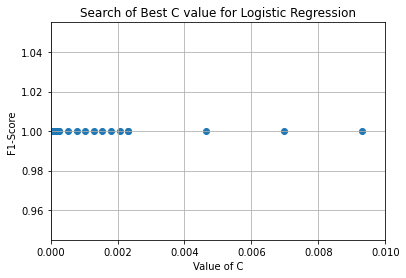

In [6]:
# Plot history
#f1_score_avg = [np.mean(x) for x in history['fscore']]
plt.scatter(history['C'], history['fscore'])
plt.xlim(best_C - 0.01, best_C + 0.01)
plt.title("Search of Best C value for Logistic Regression")
plt.xlim([0, 0.01])
plt.ylabel("F1-Score")
plt.xlabel("Value of C")
plt.grid()
plt.show()

In [7]:
best_C

2.220446049250313e-16

In [8]:
model = MyLogisReg(num_iter=100, lf=0.01, lamd=best_C)
model.fit(X_train, y_train)
pred_y = model.predict(X_test)

In [9]:
print(classification_report(y_true=y_test, y_pred=pred_y
                      #, labels=[1, 2, 3]
                     ))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       1.00      1.00      1.00        33

    accuracy                           1.00        50
   macro avg       1.00      1.00      1.00        50
weighted avg       1.00      1.00      1.00        50

